### Load Libraries

In [1]:
%matplotlib inline
import pandas as pd
from catboost import CatBoostRanker, Pool
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import ndcg_score
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

/Users/rafael/miniconda3/envs/tide/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
books_df = pd.read_csv('data/Books.csv')
users_df = pd.read_csv('data/Users.csv')
ratings_df = pd.read_csv('data/Ratings.csv')

df = pd.merge(users_df, ratings_df, on='User-ID', how='left')
df = pd.merge(df, books_df, on='ISBN', how='left')

df.head()

/var/folders/__/0vgg46cj4kd89x5czn4s5cn40000gp/T/ipykernel_21079/1997999642.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('data/Books.csv')


,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,1,"nyc, new york, usa",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"stockton, california, usa",18.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,3,"moscow, yukon territory, russia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"porto, v.n.gaia, portugal",17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"farnborough, hants, united kingdom",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Data Analysis

1. Remove observations where the user did not read the book

In [3]:
df = df[df['Book-Rating'].notnull()]

2. Check missing values
 - Replace Book-Author and Publisher with `unknown`

In [4]:
df.columns[df.isna().any()].tolist()

['Age',
 'Book-Title',
 'Book-Author',
 'Year-Of-Publication',
 'Publisher',
 'Image-URL-S',
 'Image-URL-M',
 'Image-URL-L']

In [5]:
df['Book-Author'] = df['Book-Author'].fillna('unknown')
df['Publisher'] = df['Publisher'].fillna('unknown')

3. Remove observations with missing information about the book

In [6]:
df = df[df['Book-Title'].notnull()]

4. Replace non integer Years with Nans

In [7]:
df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')

5. Check Age, Year-Of-Publication and Book-Rating distribution

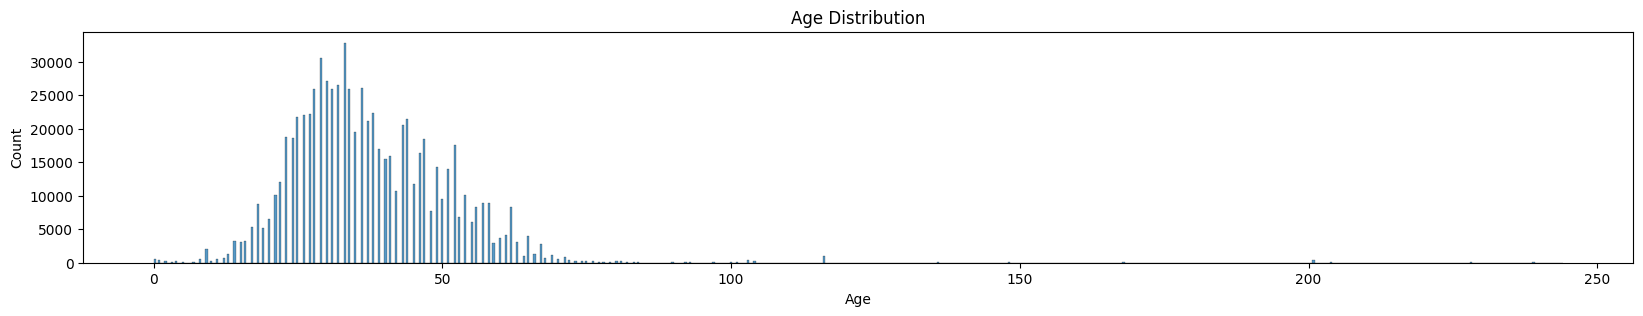

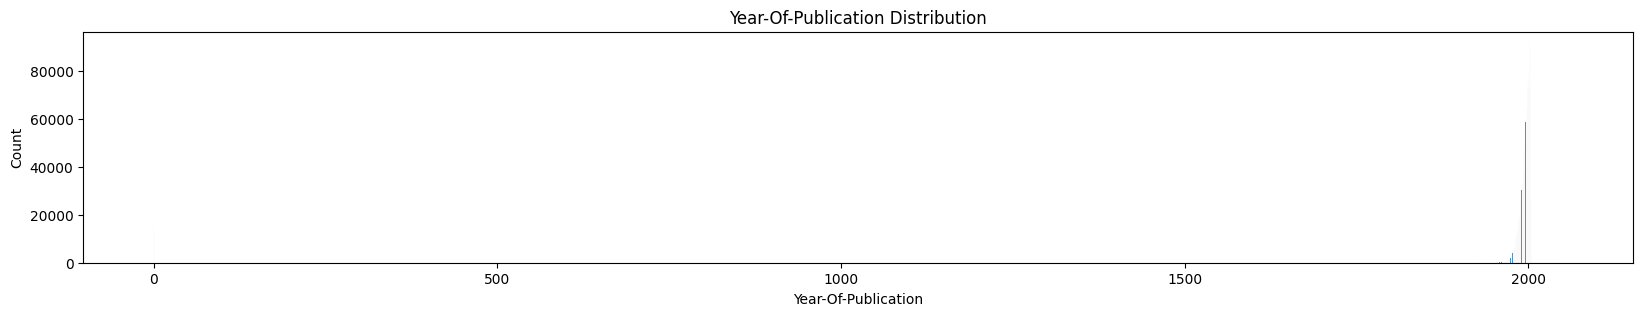

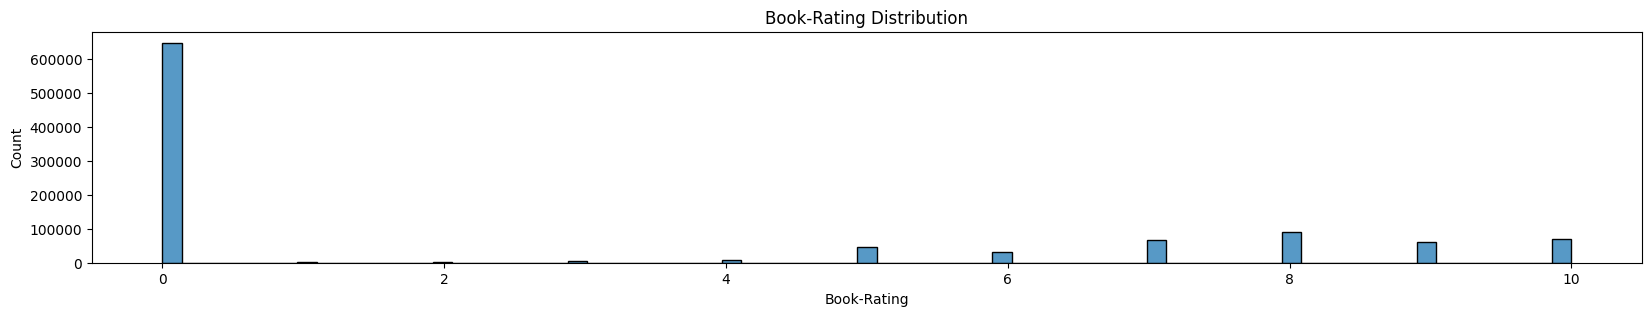

In [8]:
plt.rcParams["figure.figsize"] = (20,3)
sns.histplot(data=df, x='Age')
plt.title('Age Distribution')
plt.show()

sns.histplot(data=df, x='Year-Of-Publication')
plt.title('Year-Of-Publication Distribution')
plt.show()

sns.histplot(data=df, x='Book-Rating')
plt.title('Book-Rating Distribution')
plt.show()


6. Clean up data:
    - Replace Ages with values higher than 100 (which seems an error) with Nans
    - Replace Year-of-Publication <= 0 with median value and setting the maximum possible year to 2021
    - Remove Observations with Rating = 0, since those where books read by the user but they did not rated them
    - Create 3 features (city, state, country) from Location

In [9]:
df['Age'] = np.where(df['Age'] > 100, None, df['Age'])

df['Year-Of-Publication'] = np.where(df['Year-Of-Publication'] <= 0, np.nanmedian(df['Year-Of-Publication']), df['Year-Of-Publication']).clip(0, 2021).astype(str)

df = df[df['Book-Rating'] > 0]

df['city'] = df['Location'].apply(lambda x: x.split(',')[0].strip()) # too noisy, we will not use
df['state'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['country'] = df['Location'].apply(lambda x: x.split(',')[2].strip())

### Modeling

#### Split Test-Train Data

In [10]:
# create list with unique users
users = df['User-ID'].unique()
# shuffle list
random.shuffle(users)
# create list of users to train, to validate and to test
train_users = users[:int(0.7*len(users))]
val_users = users[int(0.7*len(users)):int(0.8*len(users))]
test_users = users[int(0.8*len(users)):]
# train, val and test df
train_df = df[df['User-ID'].isin(train_users)]
val_df = df[df['User-ID'].isin(val_users)]
test_df = df[df['User-ID'].isin(test_users)]

#### Define Features

In [14]:
EXCLUDE_FEATURES = ['city', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'ISBN', 'Location','Book-Title','Book-Rating']
CATEGORICAL_FEATURES = ['Book-Author', 'Year-Of-Publication', 'Publisher', 'state', 'country']
TARGET = ['Book-Rating']

#### Feature Transformation

1. Convert textual feature `Book-Title` into embedding vector

In [16]:
# model to create embeddings
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# train, val and test embeddings
training_books = train_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
val_books = val_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
test_books = test_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()

train_embeddings = model.encode(training_books["Book-Title"].tolist(), normalize_embeddings=True)
val_embeddings = model.encode(val_books["Book-Title"].tolist(), normalize_embeddings=True)
test_embeddings = model.encode(test_books["Book-Title"].tolist(), normalize_embeddings=True)

# reduce dimensionality with PCA
pca = PCA(n_components=0.8, random_state=42)
train_embeddings = pca.fit_transform(train_embeddings)
val_embeddings = pca.transform(val_embeddings)
test_embeddings = pca.transform(test_embeddings)

# join embeddings to dfs
train_embeddings_df = pd.DataFrame(train_embeddings)
train_embeddings_df.columns = [f"Book-Title_{i}" for i in train_embeddings_df.columns]
training_books = pd.merge(training_books.reset_index(drop=True), train_embeddings_df, left_index=True, right_index=True)
train_df = pd.merge(train_df, training_books, on=["ISBN", "Book-Title"])

val_embeddings_df = pd.DataFrame(val_embeddings)
val_embeddings_df.columns = [f"Book-Title_{i}" for i in val_embeddings_df.columns]
val_books = pd.merge(val_books.reset_index(drop=True), val_embeddings_df, left_index=True, right_index=True)
val_df = pd.merge(val_df, val_books, on=["ISBN", "Book-Title"])

test_embeddings_df = pd.DataFrame(test_embeddings)
test_embeddings_df.columns = [f"Book-Title_{i}" for i in test_embeddings_df.columns]
test_books = pd.merge(test_books.reset_index(drop=True), test_embeddings_df, left_index=True, right_index=True)
test_df = pd.merge(test_df, test_books, on=["ISBN", "Book-Title"])

2. Tranform Categorical features using Catboost Encoder for regression
 - we do not use directly in Catboost since in Catboost Ranker it generates One-Hot encoder vectors

In [6]:
encoder = CatBoostEncoder()
train_df[CATEGORICAL_FEATURES] = encoder.fit_transform(train_df[CATEGORICAL_FEATURES], train_df[TARGET])
val_df[CATEGORICAL_FEATURES] = encoder.transform(val_df[CATEGORICAL_FEATURES])
test_df[CATEGORICAL_FEATURES] = encoder.transform(test_df[CATEGORICAL_FEATURES])

### Create CatBoost Pools for train and test

In [15]:
FEATURES = [feat for feat in train_df.columns if feat not in EXCLUDE_FEATURES]

# Catboost Ranker requires sorting by groupid
train_df = train_df.sort_values(by='User-ID')
val_df = val_df.sort_values(by='User-ID')
test_df = test_df.sort_values(by='User-ID')

In [16]:
train_pool = Pool(
    data=train_df[FEATURES],
    label=train_df[TARGET],
    group_id=train_df['User-ID'].tolist(), # YetiRank applied to User-ID as query and books as documents
)
val_pool = Pool(
    data=val_df[FEATURES],
    label=val_df[TARGET],
    group_id=val_df["User-ID"].tolist(), # YetiRank applied to User-ID as query and books as documents
)
test_pool = Pool(
    data=test_df[FEATURES],
    group_id=test_df["User-ID"].tolist(), # YetiRank applied to User-ID as query and books as documents
)

#### Train and Predict with CatBoost Ranker

In [17]:
model = CatBoostRanker(loss_function="YetiRank", verbose=100)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
test_df["score"] = model.predict(test_pool)

0:	test: 0.9820663	best: 0.9820663 (0)	total: 438ms	remaining: 7m 17s
100:	test: 0.9854171	best: 0.9854408 (82)	total: 1m 2s	remaining: 9m 19s
200:	test: 0.9856747	best: 0.9856853 (193)	total: 2m 20s	remaining: 9m 19s
300:	test: 0.9857390	best: 0.9857540 (298)	total: 3m 21s	remaining: 7m 47s
400:	test: 0.9857348	best: 0.9858084 (357)	total: 4m 14s	remaining: 6m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9858084028
bestIteration = 357

Shrink model to first 358 iterations.


#### Feature Importance

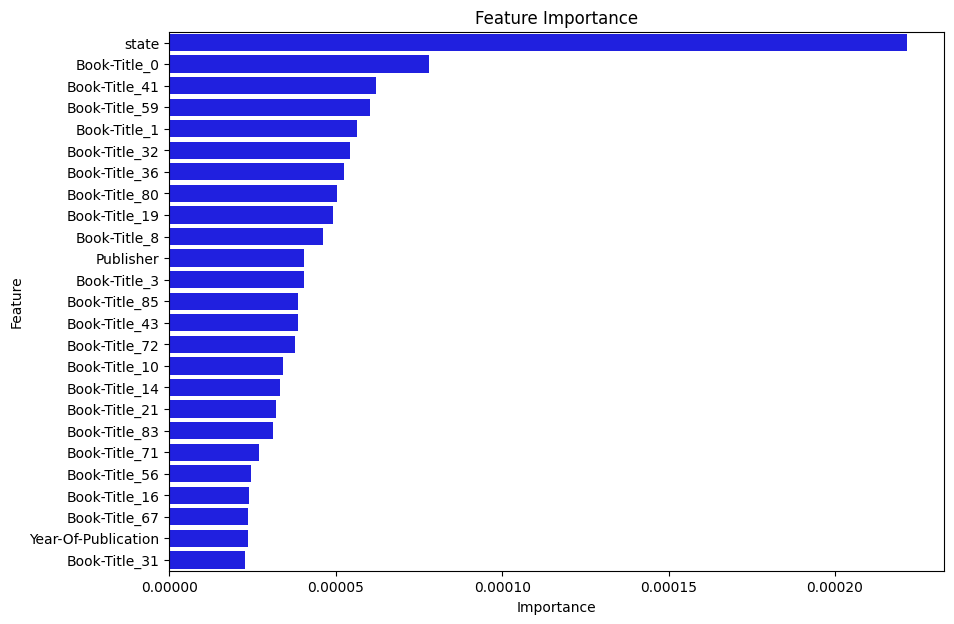

In [19]:
feature_importance = model.get_feature_importance(data=train_pool, verbose=0)
feature_importance_df = (
        pd.DataFrame(
            feature_importance,
            index=FEATURES,
            columns=["Importance"],
        )
        .sort_values(by="Importance", ascending=False)
        .reset_index()
    )

# Set the figure size
plt.figure(figsize=(10, 7))

# plot a bar chart
sns.barplot(
    x="Importance",
    y="index",
    data=feature_importance_df.iloc[:25, :],
    color="blue",
)
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.show()


#### Calculate nDCG

In [49]:
# let's use user 3542 that has more than 1 book rated
test_df[test_df['User-ID'] == 3542]

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,...,Book-Title_78,Book-Title_79,Book-Title_80,Book-Title_81,Book-Title_82,Book-Title_83,Book-Title_84,Book-Title_85,Book-Title_86,score
3444,3542,"jersey city, new jersey, usa",NaN,0312050631,5.0,Confessions of a Failed Southern Lady,8.388162,7.637947,7.533562,http://images.amazon.com/images/P/0312050631.0...,...,-0.021046,0.003304,0.144330,-0.061616,-0.062937,-0.039486,-0.022443,-0.017757,-0.047484,0.069867
3512,3542,"jersey city, new jersey, usa",NaN,0452268060,2.0,How the Garcia Girls Lost Their Accents (Plume...,7.624596,7.577403,7.557836,http://images.amazon.com/images/P/0452268060.0...,...,0.036780,-0.110356,-0.012915,0.005868,0.030071,-0.046820,0.023070,-0.070544,-0.009386,-0.126694
3483,3542,"jersey city, new jersey, usa",NaN,044651652X,3.0,The Bridges of Madison County,7.187144,7.577403,7.528039,http://images.amazon.com/images/P/044651652X.0...,...,-0.058064,-0.107017,-0.014190,-0.051545,-0.007531,-0.013312,0.052962,-0.057040,-0.019604,-0.296319
3451,3542,"jersey city, new jersey, usa",NaN,0446310786,10.0,To Kill a Mockingbird,8.834647,7.620121,8.301352,http://images.amazon.com/images/P/0446310786.0...,...,0.020245,0.097704,0.016987,-0.079456,-0.028201,0.070153,-0.054520,-0.003642,-0.031977,0.659827


In [50]:

true_relevance = np.asarray([test_df[test_df['User-ID'] == 3542][TARGET[0]].tolist()])
y_relevance = np.asarray([test_df[test_df['User-ID'] == 3542]['score'].tolist()])

ndcg_score(true_relevance, y_relevance) 

0.9955321324111159